<a href="https://colab.research.google.com/github/YichiRockyZhang/Face-Recogniton-CMSC472-Final-Project/blob/main/Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Recognition Binary Classifier

Name:  **Erik Kelemen, Daniel Gao, Yichi Zhang, Naga Nageswaren, Ashish Manda**  
Group: **Facial Recognition Group**

Link to Google Drive : **https://colab.research.google.com/drive/1HloPmg2NdLmXcCpRPS5qcaLezRQ7oW6X?usp=sharing**



**TODO:<br>
1) Load data from LFITW (Labelled Faces In The Wild) Dataset<br>
2) Augment data (mirroring, translation, cropping)<br>
3) Instantiate Dataloader<br>
4) Apply Standard NN<br>
5) Apply ConvNN<br>
6) (Moonshot) Apply SiameseNN with Triplet Loss Function<br>
7) Automate Graph Generation (can easily recycle code from P3 or P4)<br>
8) Writeup -- Results Analysis, explanation of code... (markdown cells, explain each step)**



# Part 1: Loading the Labeled Faces in the Wild (LFITW) dataset.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import scipy
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.transform import resize
from skimage.color import rgb2gray

import pandas as pd
import random
import csv

Dataset loaded from: https://www.kaggle.com/jessicali9530/lfw-dataset
1. Download kaggle.json from the group folder to your local machine. 
2. Run the code block below.
3. Upload kaggle.json when prompted.


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/lfw-dataset
! mkdir LFW
! unzip lfw-dataset.zip -d LFW
! kaggle datasets download -d jessicali9530/celeba-dataset
! unzip celeba-dataset.zip -d CalebA



In [84]:
! ls img_align_celeba_resized | wc -l

202599


In [ ]:
! zip -r resized.zip img_align_celeba_resized

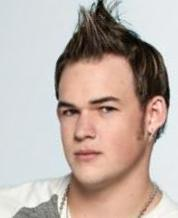

In [74]:
from IPython.display import Image, display
display(Image('CalebA/img_align_celeba/img_align_celeba/028768.jpg'))
display(Image('CalebA/img_align_celeba/img_align_celeba_resized/028768.jpg'))

In [ ]:
# ! sudo apt install imagemagick
# ! mkdir CalebA/img_align_celeba/img_align_celeba_resized
! for i in CalebA/img_align_celeba/img_align_celeba/*.jpg;do echo "$i" | cut -d '/' -f 4 && convert "$i" -resize 250x250 -background black -gravity center -extent 250x250 "CalebA/img_align_celeba/img_align_celeba_resized/$(echo "$i" | cut -d '/' -f 4)";done

Creating a Dataloader for CalebA:

In [ ]:
class CalebADataset(Dataset):
    def __init__(self, file_name, mode = 'train'):
        self.file_name = file_name
        self.mode = mode #'train', 'val', 'test']
        
        ## TODO: read data from toy_dataset.pth and set up the code such that: 
        ##      - len will return the length
        ##      - __getitem__ will return the images, with labels depending on the mode
        ##      - don't forget the mode- load train images if train, test if test, etc.
        self.images = torch.load(file_name)[mode + '_images'] #normalize()
        self.labels = torch.load(file_name)[mode + '_labels'] if self.mode != 'test'\
                    else None

    def __len__(self):
        ## TODO: Return number of images in the dataset
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        ## return image, and, if not test mode, the label at the given index
        ## valid formats include:
        ## {'image': image, 'label': label}
        ## image, label
        ## where image and label have both been converted to torch.Tensors
        img = torch.flatten(self.images[idx])/255
        return {'image': img, 'label': self.labels[idx]} if self.mode != 'test' else img

Now, use the .csv files to pull some groups of matching and mismatching faces. The .csv's are divided into individual and paired paradigms -- for now, we will follow the paired (matching vs. mismatching) sets and easily generate groups of images that we know are matches or mismatches. We will use pandas to store these csv's as DataFrames for ease of access.

In [12]:
def plot_image(im,title,cv2 = True):
    plt.figure()
    plt.imshow(im)
    plt.title(title)

In [ ]:
match_train = pd.read_csv('LFW/matchpairsDevTrain.csv')
mismatch_train = pd.read_csv('LFW/mismatchpairsDevTrain.csv')
match_test = pd.read_csv('LFW/matchpairsDevTest.csv')
mismatch_test = pd.read_csv('LFW/mismatchpairsDevTest.csv')

#print(match_train)
print(match_train.columns)
print(match_test.columns)
print(mismatch_test.columns)
print(mismatch_test.columns)
# print(mismatch_train)
# print(match_test)
# print(mismatch_test)

#given a name "firstname_lastname", image_num, return the .jpeg path associated with it
def get_path(name, num, dataset='LFW'):
  return f'LFW/lfw-deepfunneled/lfw-deepfunneled/{name}/{name}_{num:04}.jpg'

def get_img(name, num):
  return mpimg.imread(get_path(name, num))

for ind, row in match_train[:5].iterrows():
  print(row['name'])
  print(type(row))
  img1 = get_img(row['name'], row['imagenum1'])
  img2 = get_img(row['name'], row['imagenum2'])
  plot_image(img1, 'img1')
  plot_image(img2, 'img2')

Now let's see some mismatches.

AJ_Cook
<class 'pandas.core.series.Series'>
Aaron_Sorkin
<class 'pandas.core.series.Series'>
Abdel_Nasser_Assidi
<class 'pandas.core.series.Series'>
Abdoulaye_Wade
<class 'pandas.core.series.Series'>
Abdul_Rahman
<class 'pandas.core.series.Series'>


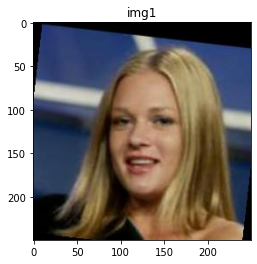

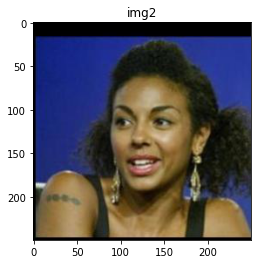

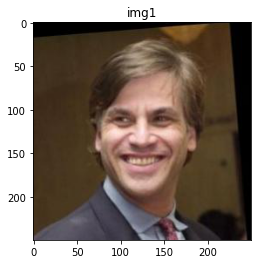

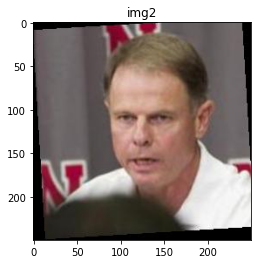

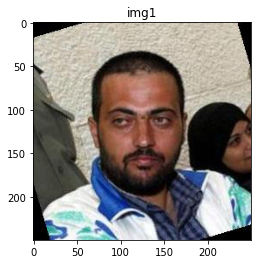

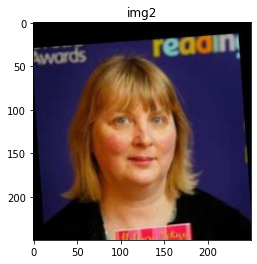

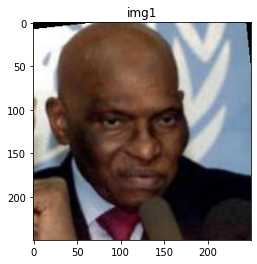

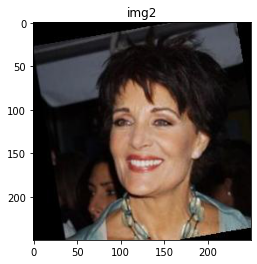

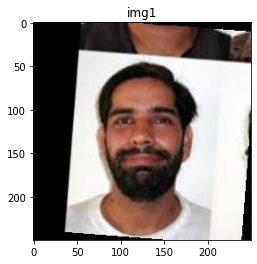

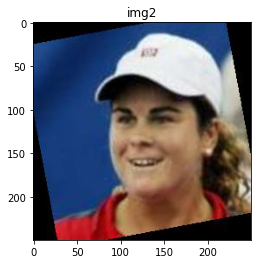

In [ ]:
for ind, row in mismatch_train[:5].iterrows():
  print(row['name'])
  print(type(row))
  img1 = get_img(row['name'], row['imagenum1'])
  img2 = get_img(row['name.1'], row['imagenum2'])
  plot_image(img1, 'img1')
  plot_image(img2, 'img2')

#Part 2: Data Loader and Data Augmentation



Code for converting .jpg to tensors for input for .pth. 
All images are 250x250 .jpg format.
We need to convert lfw-deepfunneled to a .pth file.


If we are going to grayscale, do so by calling the appropriate function below.


In [ ]:
def jpgToGrayscaleTensor(inp_jpg):
  return torch.tensor(rgb2gray(inp_jpg)).flatten()
def jpgToTensor(inp_jpg):
  return torch.tensor(inp_jpg).flatten()

This is only defined for k=2. Also, still need to implement the validation portion of database.


In [ ]:
#Converts a single .jpg to a tensor 
#need to load them then into a .pth

data = {}
match_tr, match_te, mismatch_tr, mismatch_te = [], [], [], []
#Need to write these img's into a .pth now, and we will finally have our data ready 

for ind, row in match_train.iterrows():
  img1 = jpgToTensor(get_img(row['name'], row['imagenum1']))
  img2 = jpgToTensor(get_img(row['name'], row['imagenum2']))
  match_tr.append([img1,img2])
for ind, row in match_test.iterrows():
  img1 = jpgToTensor(get_img(row['name'], row['imagenum1']))
  img2 = jpgToTensor(get_img(row['name'], row['imagenum2']))
  match_te.append([img1,img2])
for ind, row in mismatch_train.iterrows():
  img1 = jpgToTensor(get_img(row['name'], row['imagenum1']))
  img2 = jpgToTensor(get_img(row['name.1'], row['imagenum2']))
  mismatch_tr.append([img1,img2])
for ind, row in mismatch_test.iterrows():
  img1 = jpgToTensor(get_img(row['name'], row['imagenum1']))
  img2 = jpgToTensor(get_img(row['name.1'], row['imagenum2']))
  mismatch_te.append([img1,img2])

#We need to merge the two arrays together, and then shuffle them...
train_images = match_tr + match_te
train_labels = [1] * len(match_tr) + [0] * len(match_te)

#Now, to shuffle these arrays... in unison
#Can somebody double check that the below three lines work expectedly?
c = list(zip(train_images, train_labels))
random.shuffle(c)
train_images, train_labels = zip(*c)

#Now, to take the first half for training, next half for validation, and we are done
#This can be easily changed for different portions, just modify mid. 
#Can take last 1/10th for val, first 9/10th for testing, very easily
mid = len(train_images)//2
data['train_images'] = train_images[:mid]
data['train_labels'] = train_labels[:mid]
data['val_images'] = train_images[mid:]
data['val_labels'] = train_labels[mid:]
test_set = match_te + mismatch_te 
random.shuffle(test_set)
data['test_images'] = test_set


torch.save(data, "dataset.pth")


In [ ]:
#Double check dimensions, should all be equal
print(len(data['train_images']))
print(len(data['train_labels']))
print(len(data['val_images']))
print(len(data['val_labels']))
# print(train_images)
# print(train_labels)

800
800
800
800


Valid Modes: match_train, mismatch_train, match_test, mismatch_test
<br>
match labels -> 1 (all k images ARE the same person)<br>
mismatch labels -> 0 (not all k images are the same person)

In [ ]:
class MatchVMismatchDataset(Dataset):
    #mode can be 'train', 'val', or 'test'
    def __init__(self, file_name, mode = 'train'):
        self.file_name = file_name
        self.mode = mode
        
        dataset = torch.load(file_name)
        self.data = dataset[mode + '_images']
        self.len = len(self.data)
        print(type(self.data))
        if mode == 'train' or mode == 'val':
          self.labels = dataset[mode + '_labels']

    def __len__(self):
      ## TODO: Return number of images in the dataset
      return self.len
    
    def __getitem__(self, idx):
        ## return image, and, if not test mode, the label at the given index
        img = torch.flatten(self.data[idx])/255
        if self.mode == 'test':
          return img
        return img, self.labels[idx]


In [ ]:
#Generate the .pth file for torch.load("LFITWdataset_n.pth")
#Takes training set/labels, validation set/labels, and test set
#arbitrary count fold_c: 1, 2, 3...

def generate_pth_file(train_set, train_labels, val_set, val_labels, test_set,fold_c):
    if probabilities.shape[0] != 400:
        'make sure your array is the correct shape'
    else:
        save_path = 'LFITWdataset_{}.pth'.format(fold_c)
        results_obj = {}
        results_obj['train_set'] = train_set
        results_obj['train_labels'] = train_labels
        results_obj['val_set'] = val_set
        results_ob['val_labels'] = val_labels
        results_obj['test_set'] = test_set
        torch.save(results_obj, save_path)

#Part 3: Standard Neural Network

The model must be given k images -- for now, limit to k=2. Returns a BINARY ANSWER (sigmoid last act. function + rounding) -- are they k-images all of the same person or not? 
<br>Question: How should the NN be fed data to interpret multiple images? 
<br>Answer: NN must be trained on groups of images -- if every image in the group is of the same person, then label 1. Else, label 0. 

Skeleton taken from project 3, should probably be converted to cuda.

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        ## TODO: define the model
        ## REMEMBER not to change the number of layers nor the number of parameters per layer
        #reshape (250,250,3) -> (187500,1)
        self.fc1 = nn.Linear(187500, 7)
        self.fc2 = nn.Linear(7, 1)
    def forward(self, x):     
        #x is the input that we will give in the network.
        ## TODO: Implement the forward propagation function which will be called everytime during forward pass
        x = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(x))
        return out

Define Hyperparameters (To be optimized...):


In [ ]:
batch_size = 16
learning_rate = 0.005
epochs = 1500

In [ ]:
model = Net()  #making an instance of the network
optim = torch.optim.SGD(model.parameters(), lr = learning_rate)  #model.paramters() gives all the trainable paramters. 
loss_function = nn.BCELoss() 

In [ ]:
train_set = MatchVMismatchDataset('dataset.pth') ## TODO
val_set = MatchVMismatchDataset('dataset.pth', mode='val') ## TODO
test_set = MatchVMismatchDataset('dataset.pth', mode='test') ## TODO

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False) #DO NOT change the shuffle=False here!

<class 'tuple'>
<class 'tuple'>
<class 'list'>


X is a tensor of (B * 250x250x3)<br>
y is a tensor of (B) 0 or 1's



In [ ]:
all_TL = []
all_VL = []
all_VA = []
best_VA = 0.0
corr_VL = 0.0
for epoch in range(epochs):
    model.train() 
    train_loss, val_loss = [], []
    train_acc, val_acc = 0., 0.
    val_total, val_correct = 0, 0
    train_total, train_correct = 0, 0

    for idx, batch in enumerate(train_dataloader):
        #batch: list [B images of (200x200x3) each, B labels]
        X, y = batch
        optim.zero_grad()
        
        output = model.forward(X)
        output = output.to(torch.float32)
        y = y.to(torch.float32)
        y = torch.unsqueeze(y,1)
        loss = loss_function(output, y)     
        loss.backward()
        train_loss.append(loss.item())
        optim.step()
        
        for idx3, i in enumerate(output):
          if i >= 0.5 and y[idx3] == 1 or i < 0.5 and y[idx3] == 0:
            train_correct += 1
          train_total += 1
        train_acc = train_correct/train_total
        ## IMPORTANT: don't forget to call zero_grad on the optimizer between batches!!!
    #Validation phase
    model.eval()  #Setting the model to eval mode, hence making it deterministic.
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():   #Does not calulate the graidents, as in val phase its not needed. Saves on memory.
          X, y = batch
          output = model.forward(X)
          for idx, i in enumerate(output):
            if i > 0.5 and y[idx] == 1 or i <= 0.5 and y[idx] == 0:
              val_correct += 1
            val_total += 1
          output = output.to(torch.float32)
          y = y.to(torch.float32)
          y = torch.unsqueeze(y,1)
          loss2 = loss_function(output, y)
          val_loss.append(loss2.item())
    val_acc = val_correct/val_total
    all_VA.append(val_acc)
    
    if val_acc > best_VA:
      best_VA = val_acc
      best_VL = val_loss[-1]
    all_TL.append(np.mean(train_loss))
    all_VL.append(np.mean(val_loss))
    
    ## TODO: similar to training, but no need to call backward, step, or zero_grad

    ## DO NOT change the next two lines
    if epoch % 100 == 0:
        print("Epoch : {}, Train loss: {} , Train Acc: {}, Val loss: {}, Val acc: {}".format(epoch, np.mean(train_loss), train_acc, np.mean(val_loss), val_acc))

TypeError: ignored

#Part 4: Convolutional Neural Network

#Part 5: Siamese Neural Network (Moonshot)

#Part 6: Analysis